# Data Block API

The data block API lets you customize the creation  of a `DataBunch` by isolating the underlying part of that process in seperate blocks.

1. Where are the inputsand how to create them?
2. How to split the data into a training and validation sets
3. How to label the inputs?
4. What transforms to apply?
5. How to add a test set?
6. How to wrap the dataloaders and create the `dataBunch`


Eech step my be adressed with a specific block designed for the  unique setup. For example, the inputs my be in a **folder**, a **csv** or a **dataframe**. You want to split them *randomly* or by certain *indices*. For the **labels** we can have them in a **csv.file** or by **folders** or a specific **function**.

## Examples of use

Let's begin with the Traditional **MNIST** example

In [1]:
from fastai.vision import *

In [7]:
#getting the path of the mnist data
path = untar_data(URLs.MNIST_TINY)
path.ls()
tfms = get_transforms(do_flip=False)  #Transformation we remove flipping as it will ruins the digits

#contents of the datasets
path.ls()

[PosixPath('/home/anass/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/anass/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/anass/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/anass/.fastai/data/mnist_tiny/valid'),
 PosixPath('/home/anass/.fastai/data/mnist_tiny/train')]

Let's check the content of the each file and folder

In [10]:
(path/'train').ls()

[PosixPath('/home/anass/.fastai/data/mnist_tiny/train/3'),
 PosixPath('/home/anass/.fastai/data/mnist_tiny/train/7')]

We could see that's the data are splitted by folder each label lives in a specefic **folder**

In [15]:
import pandas as pd
labels = pd.read_csv(path/'labels.csv')
labels[:10]

,name,label
0,train/3/7463.png,3
1,train/3/9829.png,3
2,train/3/7881.png,3
3,train/3/8065.png,3
4,train/3/7046.png,3
5,train/3/7745.png,3
6,train/3/7156.png,3
7,train/3/8606.png,3
8,train/3/8884.png,3
9,train/3/8663.png,3


the file `labels.csv` contains the path of each file and it's label.  Could be also useful. 

Since the data is categorized by folder. We could easely use a data `ImageDataBunch` method to load it

In [16]:
data = ImageDataBunch.from_folder(path, ds_tfms = tfms, size  = 64)

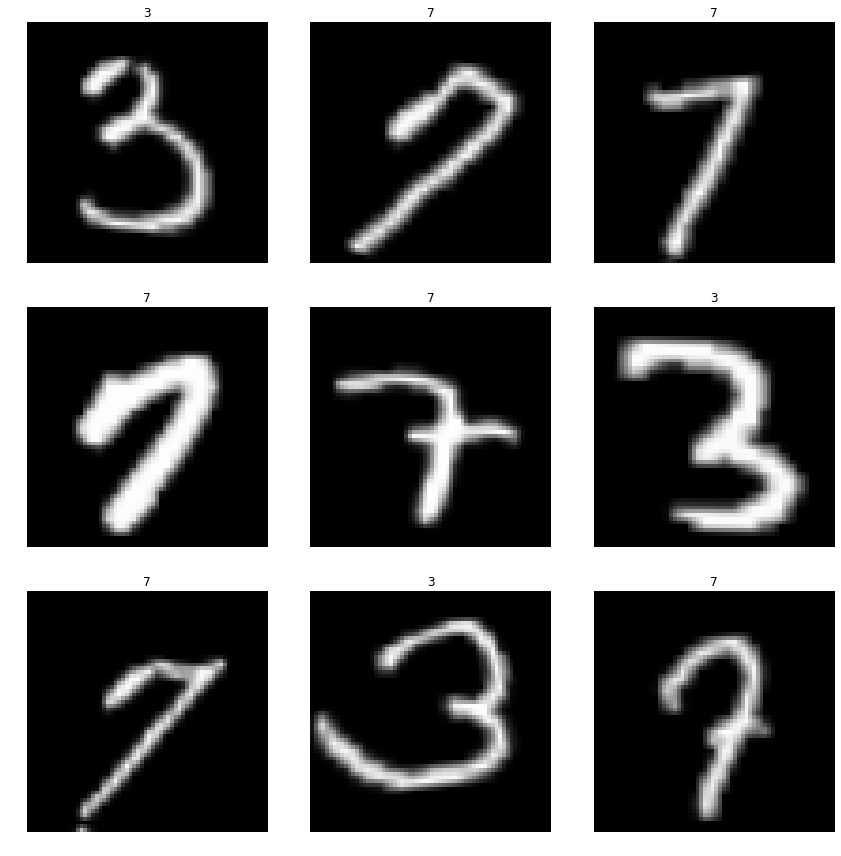

In [18]:
data.show_batch(3)

Let's achieve the same result by using the **API blocks**

In [29]:
data = (ImageList.from_folder(path)                  #where to find the data
       .split_by_folder()                            #how to split the data
       .label_from_folder()                          # how to label the data
       .add_test_folder()                           # Optional add test data
       .transform(tfms,size=64)
       .databunch()
       )

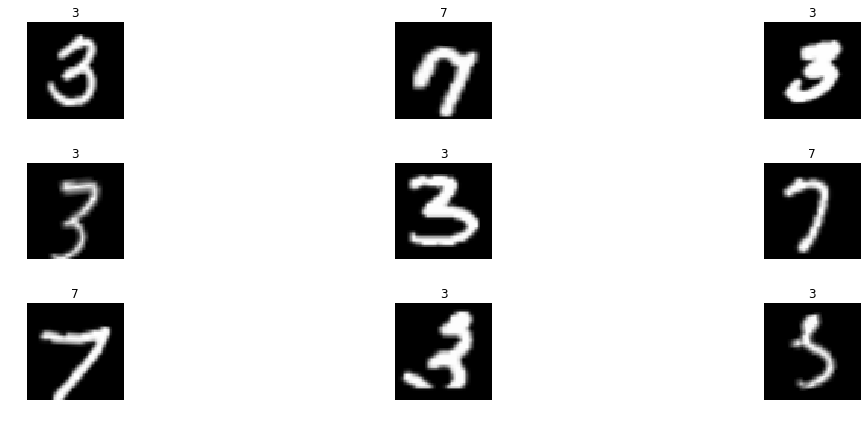

In [34]:
data.show_batch(3, figsize=(18,6),hide_axis=True)

### Planar Dataset

Now let's look to another dataset the `planar dataset`. This time it's a **multilabel** classification problem and the labels are from a **csv** files. Also there is no split between validation and training dataset.

In [36]:
path = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

path.ls()

[PosixPath('/home/anass/.fastai/data/planet_tiny/labels.csv'),
 PosixPath('/home/anass/.fastai/data/planet_tiny/train')]

In [39]:
#Let's look inside the labels.csv
planet_labels = pd.read_csv(path/'labels.csv')
planet_labels[:5]

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [44]:
#Creating the databunch

data = ImageDataBunch.from_csv(path,folder='train',ds_tfms=planet_tfms,size=128, suffix='.jpg',label_delim = ' ')

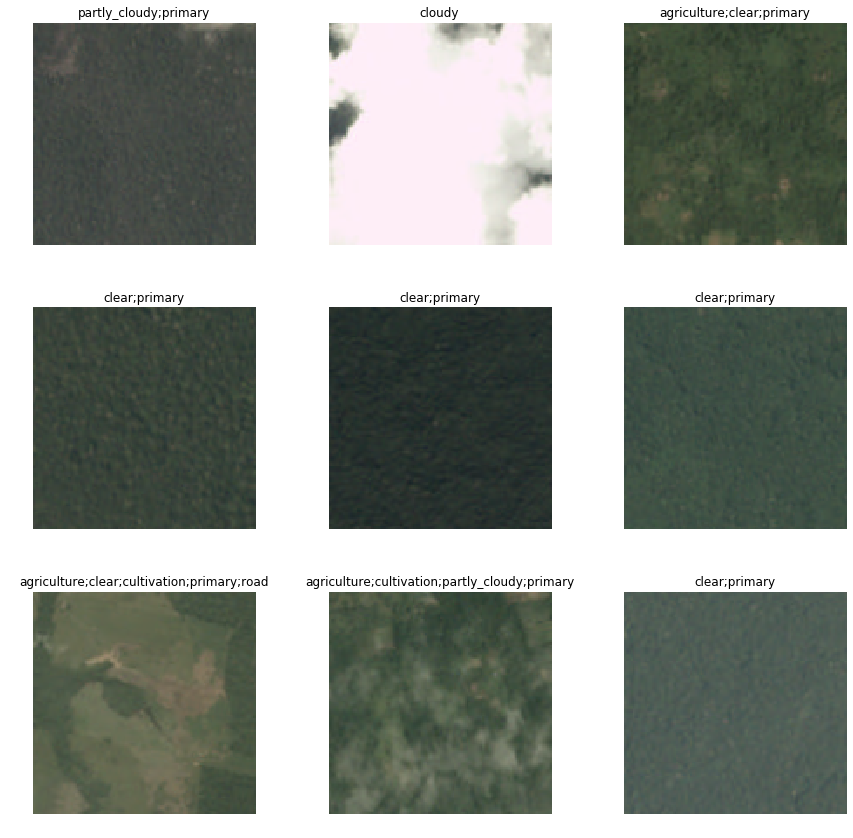

In [45]:
data.show_batch(3)

In [51]:
# Now let's  do the same by api

data = (ImageList.from_csv(path,csv_name='labels.csv',folder='train',suffix='.jpg') # Source by csv files
        .split_by_rand_pct()                                                        #how to split the data randomly 20% validation
        .label_from_df(label_delim=' ')                                             #how to label the data( use the second column in the csv)
        .transform(planet_tfms, size=128)                                            #transformation
        .databunch())

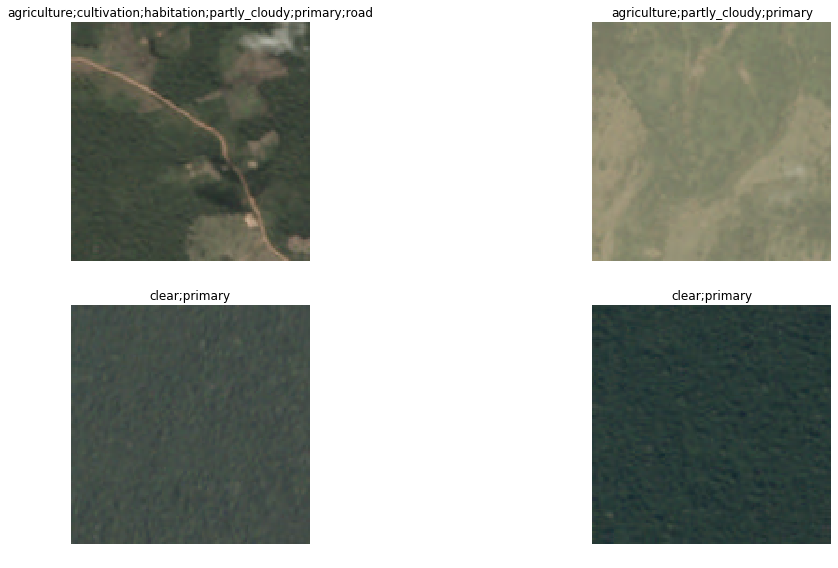

In [59]:
data.show_batch(2, figsize=(16,8))

The **DataBlock** API also allow to load a dataset in problems which there is no direct `ImageDataBucnh` factory method. As an example let's load the [camvid](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset. The images are in **images** folder and their corresponding mask are in **labels**  folder

In [78]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We also have a file to transform codes into classes in `codes.txt`

In [79]:
codes = np.loadtxt(camvid/'codes.txt',dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

All the magic is the function to get the label file from the image file

In [80]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

The method `stem` get the last part of the path and `suffix` get the file extension. 

Now we can get the databunch

In [84]:
data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=128)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch())
        #Finally -> use the defaults for conversion to databunch

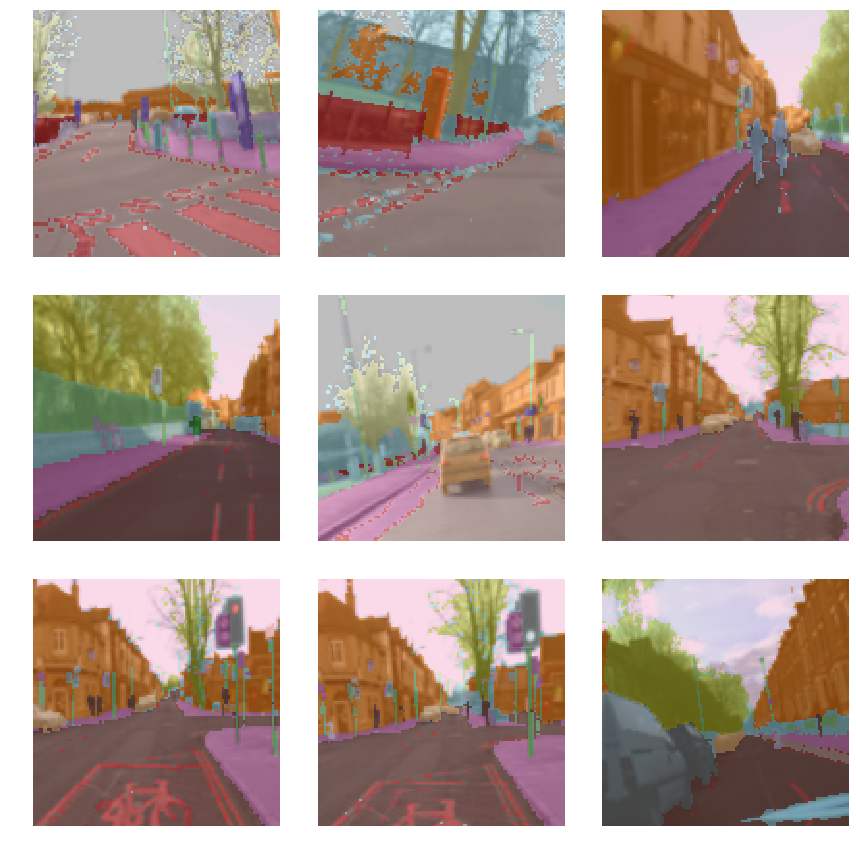

In [85]:
data.show_batch(3)

Finnaly we illustrate a Object detection problem from the [coco dataset](http://cocodataset.org/#home)

In [2]:
coco = untar_data(URLs.COCO_TINY)
coco.ls()

[PosixPath('/home/anass/.fastai/data/coco_tiny/train.json'),
 PosixPath('/home/anass/.fastai/data/coco_tiny/train')]

In [3]:
images, lbl_box = get_annotations(coco/'train.json')  #getting the list of images and ther boxes

In [5]:
img2bbox = dict(zip(images,lbl_box))
get_y_func = lambda o:img2bbox[o.name]  #constructint the bobox for each image

In [6]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

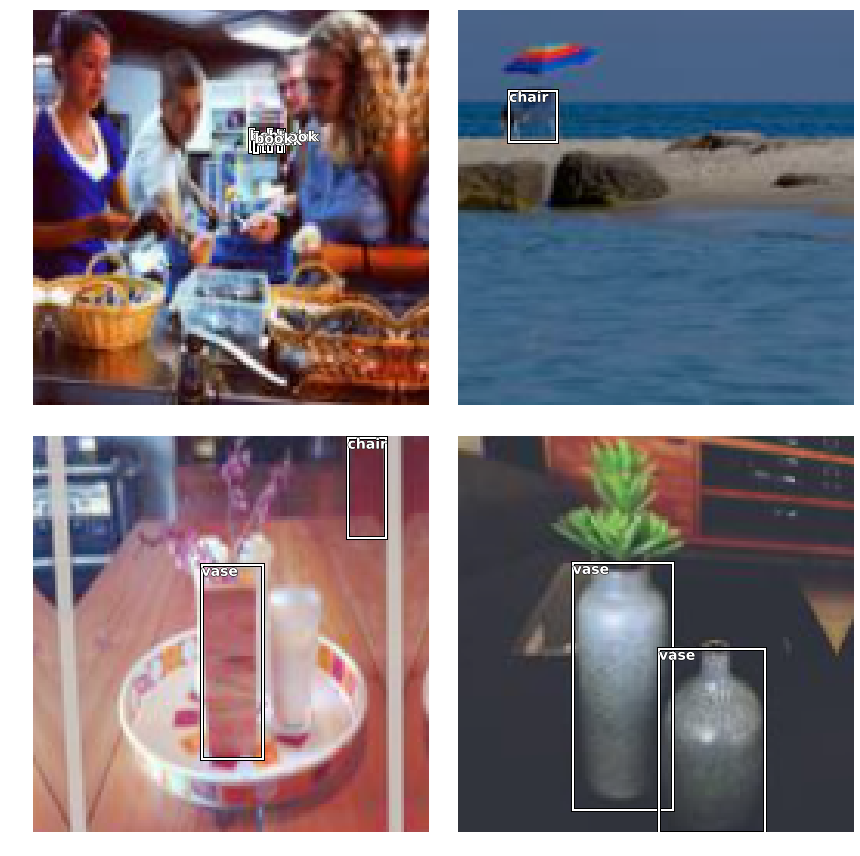

In [12]:
data.show_batch(2,ds_type=DatasetType.Train, figsize=(12,12))